In [25]:
import pandas as pd
import numpy as np
from scipy.io import arff
from scipy.stats import iqr

import os
import math

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import datetime
import calendar

from numpy import mean
from numpy import std

from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedKFold

import joblib

In [26]:
tissue = pd.read_excel('BreastTissue.xls', sheet_name = 'Data')
print(tissue.shape)
tissue.head(2)

(106, 11)


,Case #,Class,I0,PA500,HFS,DA,Area,A/DA,Max IP,DR,P
0,1,car,524.794072,0.187448,0.032114,228.800228,6843.598481,29.910803,60.204880,220.737212,556.828334
1,2,car,330.000000,0.226893,0.265290,121.154201,3163.239472,26.109202,69.717361,99.084964,400.225776


In [27]:
def print_unique(df):
    for col in df.columns:
        print(col, '\n', df[col].sort_values().unique(), '\n')
        
print_unique(tissue)

Case # 
 [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106] 

Class 
 ['adi' 'car' 'con' 'fad' 'gla' 'mas'] 

I0 
 [ 103.          121.          124.12872824  144.          145.
  152.          155.          160.32245251  172.51579725  176.
  178.          185.          195.          196.36486432  196.85671418
  197.          200.          211.          216.41325729  223.
  236.          243.29397574  245.          250.          252.
  259.88514504  260.27752103  269.49594629  272.          274.99339586
  275.67739336  281.32326291  290.45514115  294.47484562  300.
  301.30439923  303.          310.          325.

In [28]:
tissue.columns

Index(['Case #', 'Class', 'I0', 'PA500', 'HFS', 'DA', 'Area', 'A/DA', 'Max IP',
       'DR', 'P'],
      dtype='object')

In [29]:
tar = tissue['Class']
tissue.drop(['Case #', 'Class'], axis = 1, inplace = True)
tissue = tissue.join(tar)
tissue.head(2)

,I0,PA500,HFS,DA,Area,A/DA,Max IP,DR,P,Class
0,524.794072,0.187448,0.032114,228.800228,6843.598481,29.910803,60.204880,220.737212,556.828334,car
1,330.000000,0.226893,0.265290,121.154201,3163.239472,26.109202,69.717361,99.084964,400.225776,car


In [30]:
numerical = tissue.columns.drop('Class')

In [31]:
def get_snapshot(df):
    n_missing = pd.DataFrame(df.isnull().sum(), columns = ['n_missing'])
    pct_missing = pd.DataFrame(round(df.isnull().sum() / df.shape[0], 2), columns = ['pct_missing'])
    dtype = pd.DataFrame(df.dtypes, columns = ['dtype'])
    n_unique = []
    for col in df.columns:
        n_unique.append(df[col].nunique())    
    return pd.DataFrame(n_unique, index = df.columns, columns = ['n_unique']).join(dtype).join(n_missing).join(pct_missing)

In [32]:
get_snapshot(tissue)

,n_unique,dtype,n_missing,pct_missing
I0,95,float64,0,0.0
PA500,105,float64,0,0.0
HFS,103,float64,0,0.0
DA,105,float64,0,0.0
Area,105,float64,0,0.0
A/DA,105,float64,0,0.0
Max IP,105,float64,0,0.0
DR,105,float64,0,0.0
P,105,float64,0,0.0
Class,6,object,0,0.0


In [33]:
def plot_single_categorical(df, col):
    plt.figure(figsize = (4, 4))
    plt.bar(x = df[col].value_counts().index, height = df[col].value_counts(), color = mcolors.TABLEAU_COLORS)
    sns.despine(top = True)
    n_level = df[col].nunique()
    for x_coor in range(n_level):
        plt.annotate(df[col].value_counts().iloc[x_coor], 
                     xy = (x_coor, 
                           df[col].value_counts().iloc[x_coor] + df[col].value_counts().iloc[0]/50))
    plt.xticks(rotation = 0)
    plt.grid()
    plt.title(col)
    plt.show()

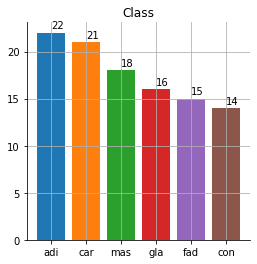

In [34]:
plot_single_categorical(tissue, 'Class')

In [76]:
tissue_dummi = pd.get_dummies(data = tissue, columns = ['Class'], dtype = int).join(tissue['Class'])

In [77]:
tissue_dummi.columns

Index(['I0', 'PA500', 'HFS', 'DA', 'Area', 'A/DA', 'Max IP', 'DR', 'P',
       'Class_adi', 'Class_car', 'Class_con', 'Class_fad', 'Class_gla',
       'Class_mas', 'Class'],
      dtype='object')

In [80]:
tissue_dummi['Class_adi'] = tissue_dummi['Class_adi'].astype(str)

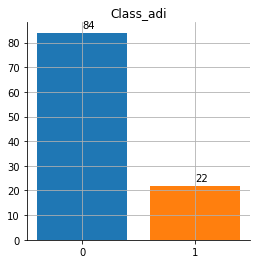

In [81]:
plot_single_categorical(tissue_dummi, 'Class_adi')

In [51]:
def scatter_fea_corr_classif_targ(df, features, target):
    corr = df[features].corr()
    n_features = len(features)
    n_sub_figs = (n_features * n_features - n_features) / 2
    if n_sub_figs < 4:
        nrows = 1
        ncols = n_sub_figs
        fig = plt.figure(figsize = (ncols * 3.75, 3))
    else:
        nrows =  math.ceil(n_sub_figs / 4)
        ncols = 4
        fig = plt.figure(figsize = (15, nrows * 3))
    
    m = 1
    for col in features:
        col_index = features.index(col)
        i = 1
        while (col_index + i) <= (n_features - 1):
            corr_val = 0
            ax = fig.add_subplot(nrows, ncols, m)
            ax = sns.scatterplot(x = col, y = features[col_index + i], hue = target, data = df)
            corr_val = round(corr.loc[col, features[col_index + i]], 2)
            plt.title(corr_val)
            
            i += 1
            m += 1
        if col_index == 0:
            break
    plt.tight_layout()
    plt.show()

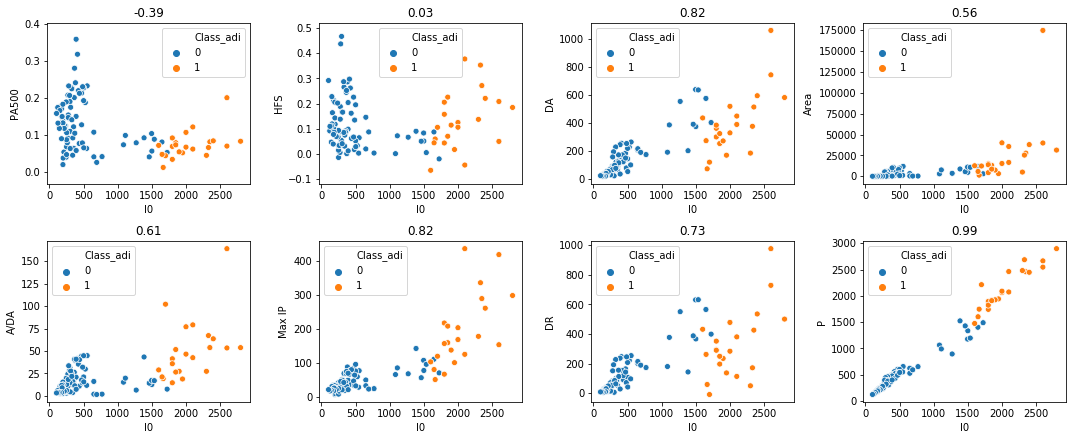

In [82]:
scatter_fea_corr_classif_targ(tissue_dummi, numerical.tolist(), 'Class_adi')

In [54]:
def feat_significance(X, y, n_feat_data_type, num):
    mi_df = pd.DataFrame(mutual_info_classif(X, y, random_state = 42), index = X.columns, columns = ['score'])
    mi_df = mi_df.sort_values(by = 'score', ascending = False)
    
    def color_cell(s):    
        background = []
        for i in range(len(s.index)):
            if s.index[i] in num:
                background.append('background-color: yellow')
            else:
                background.append('')
        return background
    
    if n_feat_data_type == 1:
        return mi_df
    else:
        return mi_df.style.apply(color_cell, axis = 0)

In [83]:
feat_score = feat_significance(tissue_dummi[numerical], tissue_dummi['Class_adi'], 1, '')
feat_score

,score
P,0.484693
I0,0.468558
Max IP,0.318336
Area,0.289473
A/DA,0.235964
DA,0.174514
DR,0.141607
PA500,0.112716
HFS,0.032547


In [59]:
def get_mean_std(df):
    mean_col = pd.DataFrame(df.mean(), columns = ['mean'])
    std_col = pd.DataFrame(df.std(), columns = ['std'])
    mean_plus_std = mean_col.join(std_col)
    return mean_plus_std

In [84]:
get_mean_std(tissue_dummi[numerical])

,mean,std
I0,784.251618,753.950075
PA500,0.120133,0.068596
HFS,0.114691,0.101347
DA,190.568642,190.801448
Area,7335.155162,18580.314213
A/DA,23.473784,23.354672
Max IP,75.381258,81.345838
DR,166.710575,181.309580
P,810.638127,763.019135


In [85]:
X = pd.DataFrame(scale(tissue_dummi[numerical]), columns = numerical)
y = tissue_dummi['Class_adi'].astype(int)

In [87]:
lr = LogisticRegression(random_state = 42)
knn = KNeighborsClassifier()
svc = SVC(random_state = 42)
tree = DecisionTreeClassifier(max_features = 'auto', random_state = 42)

In [88]:
alg_dict = {lr: 'lr', svc: 'svc', knn: 'knn', tree: 'tree'}

In [56]:
def num_feat_perform(algorithm, feat_ordered, X_ordered, y, metric):
    scores = []
    for i in range(1, len(feat_ordered)+1):
        pred_data = X_ordered.iloc[:, 0:i]
        score = mean(cross_val_score(algorithm, pred_data, y, scoring = metric, cv = 5))
        scores.append(score)

    n_features = len(feat_ordered)
    plt.plot(np.arange(n_features), scores, marker = 'x')
    plt.xticks(np.arange(n_features), np.arange(1, n_features + 1))
    for i in range(n_features):
        plt.text(i, scores[i], s = round(scores[i], 2))
    plt.grid()
    plt.xlabel('no. of features')
    plt.ylabel('score')
    
def num_feat_multi_alg(alg_dict, feat_ordered, X_ordered, y, metric):
    n_algorithm = len(alg_dict)
    algorithms = list(alg_dict.keys())
    alg_names = list(alg_dict.values())
    if n_algorithm <= 2:
        nrows = 1
        ncols = n_algorithm
        fig = plt.figure(figsize = (ncols * 6, 4))
    else:
        nrows = math.ceil(n_algorithm / 2)
        ncols = 2
        fig = plt.figure(figsize = (12, nrows * 4))

    for n in range(n_algorithm):
        ax = fig.add_subplot(nrows, ncols, n + 1)
        ax = num_feat_perform(algorithms[n], feat_ordered, X_ordered, y, metric)
        plt.title(f"'{alg_names[n]}' performance by '{metric}'")
        
    plt.tight_layout()
    plt.show()

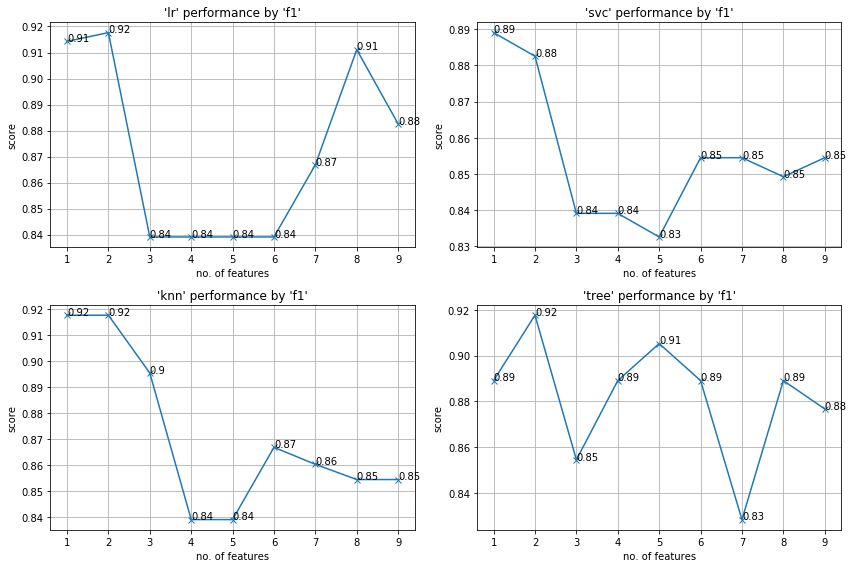

In [89]:
num_feat_multi_alg(alg_dict, feat_score.index, X[feat_score.index], y, 'f1')

In [99]:
def plot_learning_curve(train_scores, test_scores, train_sizes):
    train_scores = pd.DataFrame(train_scores, index = train_sizes, columns = ['split1', 'split2', 'split3', 'split4', 'split5'])
    train_scores = train_scores.join(pd.Series(train_scores.mean(axis = 1), name = 'mean'))

    test_scores = pd.DataFrame(test_scores, index = train_sizes, columns = ['split1', 'split2', 'split3', 'split4', 'split5'])
    test_scores = test_scores.join(pd.Series(test_scores.mean(axis = 1), name = 'mean'))

    plt.plot(train_scores['mean'], label = 'train_scores')
    plt.plot(test_scores['mean'], label = 'test_scores')
    plt.legend()
    plt.grid()
    plt.xlabel('no. of training samples')
    
def two_metric_graph(algorithm, X, y):
    train_sizes = np.linspace(start = 20, stop = X.shape[0] * 0.8, num = 6, dtype = int)
    fig = plt.figure(figsize = (10, 4))

    for i, metric in enumerate(['f1', 'balanced_accuracy']):
        train_sizes_abs, train_scores, test_scores = learning_curve(algorithm, X, y, train_sizes = train_sizes, 
                                                                    scoring = metric, cv = 5, shuffle = True, 
                                                                    random_state = 42)
        ax = fig.add_subplot(1, 2, i + 1)
        ax = plot_learning_curve(train_scores, test_scores, train_sizes)
        plt.title(f"'performance by '{metric}'")

    plt.tight_layout()
    plt.show()
    
def two_metric_multi_alg(alg_dict, X, y):
    algorithms = list(alg_dict.keys())
    alg_names = list(alg_dict.values())

    for i in range(len(alg_dict)):
        print(f"'{alg_names[i]}' to be implemented:")
        two_metric_graph(algorithms[i], X, y)

'knn' to be implemented:


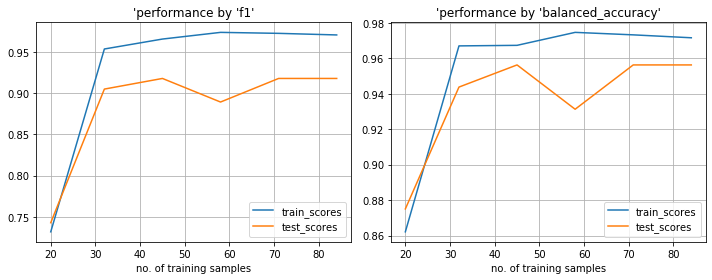

In [101]:
two_metric_multi_alg({knn: 'knn'}, X[feat_score.index[0:1]], y)

In [102]:
feat_score.index[0]

'P'

In [104]:
knn.fit(X[['P']], y)
joblib.dump(knn, 'knn.joblib')

['knn.joblib']